In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
from scipy import stats as st
from google.colab import drive

import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split

import os

import scipy

from keras import metrics

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles.csv')

In [3]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long
0,0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164
3,3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304
4,4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444


In [4]:
len(tiles)

12227

Split street characterstics into tiles

Stop signs <br>
https://data.sfgov.org/Transportation/Stop-Signs/4542-gpa3

In [5]:
stops = pd.read_csv(r'/content/drive/MyDrive/capstone/Stop_Signs.csv')
stops.head(5)

,STREET,X_STREET,DIRECTION,ST_FACING,DIST,CNN,CONCATENAT,MTAB_DATE,MTAB_RESO_TEXT,MTAB_MOTION,STATUS,WORKORDER,INSTALL_DATE,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,MORAGA ST,45TH AVE,NE,WB,0,27930000.0,MORAGA ST & 45TH AVE,2.021062e+13,NaN,6423,I,21-02595,2.021072e+13,POINT (-122.50446 37.75488),39.0,39.0,10,7,35
1,PERU,ATHENS,NaN,EB,NaN,21652000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.42493 37.726322),90.0,90.0,9,1,7
2,LA PLAYA ST,JUDAH,NW,SB,0,27960000.0,LA PLAYA ST & JUDAH,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.50914 37.76028),39.0,39.0,10,7,35
3,37TH AVE,CABRILLO,NW,SB,0,27863000.0,37TH AVE & CABRILLO,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.497185 37.77385),8.0,8.0,8,4,29
4,PRESIDIO,GEARY,SE,NB,NaN,26834000.0,PRESIDIO AVE & GEARY BLVD,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-122.44582 37.78249),13.0,13.0,8,6,18


In [6]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STREET                        10639 non-null  object 
 1   X_STREET                      10639 non-null  object 
 2   DIRECTION                     9895 non-null   object 
 3   ST_FACING                     10639 non-null  object 
 4   DIST                          7028 non-null   object 
 5   CNN                           10624 non-null  float64
 6   CONCATENAT                    10420 non-null  object 
 7   MTAB_DATE                     576 non-null    float64
 8   MTAB_RESO_TEXT                2 non-null      object 
 9   MTAB_MOTION                   586 non-null    object 
 10  STATUS                        1615 non-null   object 
 11  WORKORDER                     438 non-null    object 
 12  INSTALL_DATE                  334 non-null    float64
 13  s

In [7]:
# all stop signs have lat/long 
pd.notnull(stops['shape']).unique()

array([ True])

In [8]:
import re

stop_lat = []
stop_long = []
for i in stops['shape']: 
    split = re.split(' |\(|\)', i)
    stop_lat = np.append(stop_lat, float(split[3]))
    stop_long = np.append(stop_long, float(split[2]))
    
stops['latitude'] = stop_lat
stops['longitude'] = stop_long

In [9]:
stops.head(5)

,STREET,X_STREET,DIRECTION,ST_FACING,DIST,CNN,CONCATENAT,MTAB_DATE,MTAB_RESO_TEXT,MTAB_MOTION,...,WORKORDER,INSTALL_DATE,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,latitude,longitude
0,MORAGA ST,45TH AVE,NE,WB,0,27930000.0,MORAGA ST & 45TH AVE,2.021062e+13,NaN,6423,...,21-02595,2.021072e+13,POINT (-122.50446 37.75488),39.0,39.0,10,7,35,37.754880,-122.504460
1,PERU,ATHENS,NaN,EB,NaN,21652000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.42493 37.726322),90.0,90.0,9,1,7,37.726322,-122.424930
2,LA PLAYA ST,JUDAH,NW,SB,0,27960000.0,LA PLAYA ST & JUDAH,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.50914 37.76028),39.0,39.0,10,7,35,37.760280,-122.509140
3,37TH AVE,CABRILLO,NW,SB,0,27863000.0,37TH AVE & CABRILLO,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.497185 37.77385),8.0,8.0,8,4,29,37.773850,-122.497185
4,PRESIDIO,GEARY,SE,NB,NaN,26834000.0,PRESIDIO AVE & GEARY BLVD,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.44582 37.78249),13.0,13.0,8,6,18,37.782490,-122.445820


In [10]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STREET                        10639 non-null  object 
 1   X_STREET                      10639 non-null  object 
 2   DIRECTION                     9895 non-null   object 
 3   ST_FACING                     10639 non-null  object 
 4   DIST                          7028 non-null   object 
 5   CNN                           10624 non-null  float64
 6   CONCATENAT                    10420 non-null  object 
 7   MTAB_DATE                     576 non-null    float64
 8   MTAB_RESO_TEXT                2 non-null      object 
 9   MTAB_MOTION                   586 non-null    object 
 10  STATUS                        1615 non-null   object 
 11  WORKORDER                     438 non-null    object 
 12  INSTALL_DATE                  334 non-null    float64
 13  s

In [11]:
stop = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(stops[(stops['latitude'] < lat2) & (stops['latitude'] > lat1) & (stops['longitude'] > long2) & (stops['longitude'] < long1)])
    stop = np.append(stop,f)

In [12]:
tiles['Stop_Signs'] = stop

In [13]:
tiles[tiles['Stop_Signs'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0
20,20,20,37.708251,37.709155,-122.414116,-122.415256,37.708703,-122.414686,3.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0
...,...,...,...,...,...,...,...,...,...
11995,11995,11995,37.805840,37.806744,-122.423237,-122.424377,37.806292,-122.423807,3.0
12005,12005,12005,37.805840,37.806744,-122.434638,-122.435778,37.806292,-122.435208,3.0
12009,12009,12009,37.805840,37.806744,-122.439198,-122.440338,37.806292,-122.439768,4.0
12055,12055,12055,37.806744,37.807648,-122.418676,-122.419816,37.807196,-122.419246,5.0


In [14]:
bus_stops = pd.read_csv(r'/content/drive/MyDrive/capstone/Muni_Stops.csv')
bus_stops.head(5)

,OBJECTID,STOPNAME,TRAPEZESTOPABBR,RUCUSSTOPABBR,STOPID,LATITUDE,LONGITUDE,ACCESSIBILITYMASK,ATSTREET,ONSTREET,...,INSERT_TIMESTAMP,SDE_ID,SIGNUPID,SUPERVISOR_DISTRICT,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,36073,Powell St&Francisco St SE-NS/BZ,POWLFNC1,POWLFNCO,6056,37.804810,-122.411650,0.0,FRANCISCO ST,POWELL ST,...,20220727151100,14257412,134,NaN,POINT (-122.41165 37.80481),106.0,106.0,6.0,3.0,23.0
1,33704,Chestnut St&Laguna St SW-NS/BZ,CHESLGN1,CHESLGNA,3948,37.801370,-122.431406,0.0,LAGUNA ST,CHESTNUT ST,...,20220727151100,14253217,134,NaN,POINT (-122.431404 37.80137),17.0,17.0,4.0,6.0,13.0
2,33872,Geary Blvd&Fillmore St NW-FS/BZ,GEARFIL0,GEARFILL,4295,37.784391,-122.433050,0.0,AVERY ST,GEARY BLVD,...,20220727151100,14253429,134,NaN,POINT (-122.43305 37.78439),103.0,103.0,4.0,11.0,39.0
3,33441,3rd St&Folsom St N-FS/BZ,.3STFOL0,3STFOLS,3124,37.784204,-122.399326,0.0,CLEMENTINA ST,03RD ST,...,20220727151100,14252566,134,NaN,POINT (-122.39932 37.784203),32.0,32.0,1.0,10.0,8.0
4,35962,Presidio Ave&Sutter St NE-FS/PS,PRESSUT1,PRESSUTT,6098,37.784535,-122.446197,0.0,SUTTER ST,PRESIDIO AVE,...,20220727151100,14258040,134,NaN,POINT (-122.4462 37.784534),103.0,103.0,8.0,6.0,31.0


In [15]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249 entries, 0 to 3248
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OBJECTID                      3249 non-null   int64  
 1   STOPNAME                      3249 non-null   object 
 2   TRAPEZESTOPABBR               3249 non-null   object 
 3   RUCUSSTOPABBR                 2874 non-null   object 
 4   STOPID                        3249 non-null   int64  
 5   LATITUDE                      3249 non-null   float64
 6   LONGITUDE                     3249 non-null   float64
 7   ACCESSIBILITYMASK             3063 non-null   float64
 8   ATSTREET                      3162 non-null   object 
 9   ONSTREET                      3243 non-null   object 
 10  POSITION                      2862 non-null   object 
 11  ORIENTATION                   2884 non-null   object 
 12  SERVICEPLANNINGSTOPTYPE       1573 non-null   object 
 13  SHE

In [16]:
bus_stop = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(bus_stops[(bus_stops['LATITUDE'] < lat2) & (bus_stops['LATITUDE'] > lat1) & (bus_stops['LONGITUDE'] > long2) & (bus_stops['LONGITUDE'] < long1)])
    bus_stop = np.append(bus_stop,f)

In [17]:
tiles['Bus_stop'] = bus_stop

In [18]:
tiles[tiles['Bus_stop'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0,1.0
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0,5.0
18,18,18,37.708251,37.709155,-122.411836,-122.412976,37.708703,-122.412406,0.0,2.0
25,25,25,37.708251,37.709155,-122.419816,-122.420956,37.708703,-122.420386,1.0,4.0
27,27,27,37.708251,37.709155,-122.422097,-122.423237,37.708703,-122.422667,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
12104,12104,12104,37.807648,37.808551,-122.409555,-122.410695,37.808099,-122.410125,0.0,1.0
12105,12105,12105,37.807648,37.808551,-122.410695,-122.411836,37.808099,-122.411266,0.0,1.0
12106,12106,12106,37.807648,37.808551,-122.411836,-122.412976,37.808099,-122.412406,0.0,1.0
12109,12109,12109,37.807648,37.808551,-122.415256,-122.416396,37.808099,-122.415826,0.0,1.0


Street Paving <br>
https://data.sfgov.org/d/5wbp-dwzt/about

In [19]:
paving_all = pd.read_csv(r'/content/drive/MyDrive/capstone/Utility_Excavation_Moratorium_Streets.csv')
paving_all.head(5)

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,13730000,WOOLSEY ST,BOWDOIN ST to DARTMOUTH ST (800 - 899),2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34852,6.009288e+06,2.091470e+06,37.723302,-122.410007,"(37.72330157541044, -122.41000739523302)",NaN,NaN,NaN,NaN,NaN,NaN
1,13731000,WOOLSEY ST,DARTMOUTH ST to COLBY ST (900 - 999),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34854,6.009001e+06,2.091382e+06,37.723044,-122.410993,"(37.72304412011837, -122.41099254630903)",NaN,NaN,NaN,NaN,NaN,NaN
2,13732000,WOOLSEY ST,COLBY ST to UNIVERSITY ST (1000 - 1099),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34856,6.008715e+06,2.091294e+06,37.722787,-122.411977,"(37.72278693382726, -122.41197662933816)",NaN,NaN,NaN,NaN,NaN,NaN
3,20876000,WOOLSEY ST,COLBY ST intersection,2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34855,6.008858e+06,2.091338e+06,37.722915,-122.411485,"(37.72291542361495, -122.41148498754468)",NaN,NaN,NaN,NaN,NaN,NaN
4,20868000,WOOLSEY ST,BOWDOIN ST intersection,2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34851,6.009431e+06,2.091514e+06,37.723430,-122.409515,"(37.72343033432908, -122.4095146857055)",NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2020']

In [21]:
#paving.head(5)

In [22]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2022']
paving = paving_all

pave = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(paving[(paving['Latitude'] < lat2) & (paving['Latitude'] > lat1) & (paving['Longitude'] > long2) & (paving['Longitude'] < long1)])
    pave = np.append(pave,f)

In [23]:
from datetime import datetime as dt
a = dt.strptime("10/12/13", "%m/%d/%y")
b = dt.strptime("10/15/13", "%m/%d/%y")
a > b
a < b

True

In [24]:
#Split pavement data between date groups A: 10/1/2018 - 9/30/2020 and B: 10/1/2020 - 9/30/2022

def date_group(x):
    x = dt.strptime(x, "%m/%d/%Y %H:%M:%S %p")
    if (x >= dt.strptime("10/1/2018", "%m/%d/%Y")) & (x <= dt.strptime("9/30/2020", "%m/%d/%Y")):
        return "H"
    if (x >= dt.strptime("10/1/2020", "%m/%d/%Y")) & (x <= dt.strptime("9/30/2022", "%m/%d/%Y")):
        return "F"

paving['Paving_date_group'] = paving['EffectiveDate'].apply(date_group)

In [25]:
#pavement data date groups A: 10/1/2018 - 9/30/2020
paving[paving['Paving_date_group']=='H']

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Paving_date_group
37,28018000,CALIFORNIA ST,29TH AVE intersection,2792J,04/13/2020 12:00:00 AM,04/13/2025 12:00:00 AM,04/22/2020 02:31:50 PM,8390,5.986830e+06,2.113930e+06,37.783689,-122.489290,"(37.78368859874989, -122.48928978213416)",NaN,NaN,NaN,NaN,NaN,NaN,H
53,26972000,CHESTNUT ST,SCOTT ST intersection,2498J,01/01/2019 12:00:00 AM,01/01/2024 12:00:00 AM,05/13/2019 12:45:05 PM,9383,6.000855e+06,2.119646e+06,37.800190,-122.441177,"(37.80019017258282, -122.44117737587483)",NaN,NaN,NaN,NaN,NaN,NaN,H
56,28180000,UNION ST,SONOMA ST intersection,2794J,03/06/2019 12:00:00 AM,03/06/2024 12:00:00 AM,03/06/2019 12:52:45 PM,32689,6.010903e+06,2.119656e+06,37.800786,-122.406408,"(37.80078640332124, -122.40640795436289)",NaN,NaN,NaN,NaN,NaN,NaN,H
67,13302000,VIENNA ST,PERSIA AVE to RUSSIA AVE (500 - 599),2633J,07/01/2019 12:00:00 AM,07/01/2024 12:00:00 AM,10/24/2019 08:47:31 AM,33783,6.003191e+06,2.090282e+06,37.719697,-122.430998,"(37.71969693919677, -122.43099848723189)",NaN,NaN,NaN,NaN,NaN,NaN,H
85,3603000,CALIFORNIA ST,26TH AVE to 27TH AVE (6400 - 6499),2792J,05/22/2020 12:00:00 AM,05/22/2025 12:00:00 AM,05/22/2020 01:59:03 PM,8385,5.987602e+06,2.113958e+06,37.783809,-122.486620,"(37.783809441173005, -122.48661971093952)",NaN,NaN,NaN,NaN,NaN,NaN,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,11523000,SANCHEZ ST,21ST ST to HILL ST (800 - 851),2795J,07/01/2019 12:00:00 AM,07/01/2024 12:00:00 AM,07/05/2019 04:34:20 PM,29430,6.003730e+06,2.103477e+06,37.755958,-122.430077,"(37.75595810104582, -122.43007660533519)",NaN,NaN,NaN,NaN,NaN,NaN,H
3962,26583000,UNION ST,LAGUNA ST intersection,2937J,01/25/2020 12:00:00 AM,01/25/2025 12:00:00 AM,04/28/2020 02:50:16 PM,32743,6.003904e+06,2.118682e+06,37.797716,-122.430559,"(37.79771619918379, -122.43055895969401)",NaN,NaN,NaN,NaN,NaN,NaN,H
3964,13011000,UPLAND DR,SAN ALESO AVE to APTOS AVE (451 - 599),2793J,08/09/2019 12:00:00 AM,08/09/2024 12:00:00 AM,12/16/2019 04:02:52 PM,33026,5.993197e+06,2.094333e+06,37.730249,-122.465839,"(37.73024862557529, -122.465838675013)",NaN,NaN,NaN,NaN,NaN,NaN,H
3967,22792000,SAN FERNANDO WAY,DARIEN WAY intersection,10033406,03/29/2019 12:00:00 AM,03/29/2024 12:00:00 AM,06/17/2019 08:47:03 AM,29141,5.992115e+06,2.094949e+06,37.731878,-122.469625,"(37.73187806319072, -122.46962476562045)",NaN,NaN,NaN,NaN,NaN,NaN,H


In [26]:
#pavement data between date groups B: 10/1/2020 - 9/30/2022
paving[paving['Paving_date_group']=='F']

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Paving_date_group
0,13730000,WOOLSEY ST,BOWDOIN ST to DARTMOUTH ST (800 - 899),2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34852,6.009288e+06,2.091470e+06,37.723302,-122.410007,"(37.72330157541044, -122.41000739523302)",NaN,NaN,NaN,NaN,NaN,NaN,F
1,13731000,WOOLSEY ST,DARTMOUTH ST to COLBY ST (900 - 999),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34854,6.009001e+06,2.091382e+06,37.723044,-122.410993,"(37.72304412011837, -122.41099254630903)",NaN,NaN,NaN,NaN,NaN,NaN,F
2,13732000,WOOLSEY ST,COLBY ST to UNIVERSITY ST (1000 - 1099),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34856,6.008715e+06,2.091294e+06,37.722787,-122.411977,"(37.72278693382726, -122.41197662933816)",NaN,NaN,NaN,NaN,NaN,NaN,F
3,20876000,WOOLSEY ST,COLBY ST intersection,2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34855,6.008858e+06,2.091338e+06,37.722915,-122.411485,"(37.72291542361495, -122.41148498754468)",NaN,NaN,NaN,NaN,NaN,NaN,F
4,20868000,WOOLSEY ST,BOWDOIN ST intersection,2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34851,6.009431e+06,2.091514e+06,37.723430,-122.409515,"(37.72343033432908, -122.4095146857055)",NaN,NaN,NaN,NaN,NaN,NaN,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,10254000,PARIS ST,PERSIA AVE to RUSSIA AVE (400 - 499),2927J,01/01/2021 12:00:00 AM,01/01/2026 12:00:00 AM,03/17/2021 10:52:38 AM,26190,6.002049e+06,2.091000e+06,37.721604,-122.434996,"(37.72160439318569, -122.43499571759517)",NaN,NaN,NaN,NaN,NaN,NaN,F
3945,25756000,CASTRO ST,20TH ST intersection,2463J,01/25/2022 12:00:00 AM,01/25/2027 12:00:00 AM,01/31/2022 01:49:40 PM,8845,6.002407e+06,2.104134e+06,37.757687,-122.434698,"(37.757686529927035, -122.43469758350022)",NaN,NaN,NaN,NaN,NaN,NaN,F
3948,10225000,PALOU AVE,PHELPS ST to DUNSHEE ST (1800 - 1859),2461J,12/15/2020 12:00:00 AM,12/15/2025 12:00:00 AM,12/30/2020 01:13:54 PM,26127,6.013674e+06,2.096149e+06,37.736396,-122.395174,"(37.736396381947166, -122.39517384138189)",NaN,NaN,NaN,NaN,NaN,NaN,F
3950,13760000,YORBA ST,SUNSET BLVD to 37TH AVE (2550 - 2599),10036423,12/31/2020 12:00:00 AM,12/31/2025 12:00:00 AM,01/05/2021 11:09:00 AM,34962,5.985021e+06,2.096206e+06,37.734917,-122.494239,"(37.7349170797637, -122.49423912331456)",NaN,NaN,NaN,NaN,NaN,NaN,F


In [27]:
tiles['Paving'] = pave

In [28]:
tiles[tiles['Paving'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0,5.0,4.0
14,14,14,37.708251,37.709155,-122.407275,-122.408415,37.708703,-122.407845,0.0,0.0,1.0
19,19,19,37.708251,37.709155,-122.412976,-122.414116,37.708703,-122.413546,0.0,0.0,1.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0,0.0,1.0
22,22,22,37.708251,37.709155,-122.416396,-122.417536,37.708703,-122.416966,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12107,12107,12107,37.807648,37.808551,-122.412976,-122.414116,37.808099,-122.413546,0.0,0.0,1.0
12108,12108,12108,37.807648,37.808551,-122.414116,-122.415256,37.808099,-122.414686,0.0,0.0,3.0
12109,12109,12109,37.807648,37.808551,-122.415256,-122.416396,37.808099,-122.415826,0.0,1.0,2.0
12110,12110,12110,37.807648,37.808551,-122.416396,-122.417536,37.808099,-122.416966,0.0,0.0,2.0


311 Cases <br>
https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6

In [29]:
#cases = pd.read_csv(r'.\Data\311_Cases.csv')
#cases.head(5)

In [30]:
#stop = []
#for i in range(len(tiles)):
#    ti = tiles.iloc[i]
#    lat1 = ti['Lat1']
#    lat2 = ti['Lat2']
#    long1 = ti['Long1']
#    long2 = ti['Long2']
#    f = len(stop[(stop['latitude'] < lat2) & (stop['latitude'] > lat1) & (stop['longitude'] > long2) & (stop['longitude'] < long1)])
#    stop = np.append(stop,f)

In [31]:
#tiles['Stop_Signs'] = stop

Split historical and future collision data into tiles

In [32]:
collisions = pd.read_csv(r'/content/drive/MyDrive/capstone/transbase_collisions_02112023.csv')
collisions.head(5)

#collisions.columns

# dataset is from 2017 - September 30 2022
# Historical Group: Oct 1 2018 - September 30 2020
# Future Group: Oct 1 2020 - September 30 2022

collisions['Historical'] = np.where((collisions['collision_date'] >= 20181001) & (collisions['collision_date'] <= 20200930),1,0)

collisions['Future'] = np.where((collisions['collision_date'] >= 20201001) & (collisions['collision_date'] <= 20220930),1,0)

collisions.head(5)

,type,geometry,case_id_pkey,collision_severity,accident_year,collision_date,collision_time,distance,direction,pcf_viol_category,...,bndy_type,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,Historical,Future
0,Feature,[object Object],17045414,Injury (Complaint of Pain),2017,20171227,1849.0,0,Not Stated,Unknown,...,Geographic Boundary,1.0,Driver,South,Proceeding Straight,Driver,East,Proceeding Straight,0,0
1,Feature,[object Object],170800277,Injury (Complaint of Pain),2017,20171001,145.0,28,South,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,North,Proceeding Straight,Driver,North,Making Left Turn,0,0
2,Feature,[object Object],170800299,Injury (Other Visible),2017,20171001,233.0,0,Not Stated,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,East,Making Left Turn,Driver,South,Proceeding Straight,0,0
3,Feature,[object Object],170801106,Injury (Other Visible),2017,20171001,1228.0,99,East,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,West,Making U Turn,Bicyclist,West,Proceeding Straight,0,0
4,Feature,[object Object],170801225,Injury (Complaint of Pain),2017,20171001,1300.0,210,North,Opening door on traffic side when unsafe,...,Geographic Boundary,1.0,Other,South,Stopped In Road,Driver,South,Passing Other Vehicle,0,0


In [33]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14866 entries, 0 to 14865
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     14866 non-null  object 
 1   geometry                 14866 non-null  object 
 2   case_id_pkey             14866 non-null  object 
 3   collision_severity       14866 non-null  object 
 4   accident_year            14866 non-null  int64  
 5   collision_date           14866 non-null  int64  
 6   collision_time           14858 non-null  float64
 7   distance                 14866 non-null  int64  
 8   direction                14866 non-null  object 
 9   pcf_viol_category        14866 non-null  object 
 10  pcf_violation            14833 non-null  object 
 11  pcf_viol_subsection      0 non-null      float64
 12  type_of_collision        14866 non-null  object 
 13  mviw                     14866 non-null  object 
 14  street_view           

In [34]:
collisions['collision_severity'].unique()

array(['Injury (Complaint of Pain)', 'Injury (Other Visible)',
       'Injury (Severe)', 'Fatal'], dtype=object)

In [35]:
# adding historical and future collisions to data frame

# 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'
collisions_fh = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]
# for every tile, sum the future and historical collisions 
# the collision should take place within the tile 
fut = []
his = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(collisions_f[(collisions_f['latitude'] < lat2) & (collisions_f['latitude'] > lat1) & (collisions_f['longitude'] > long2) & (collisions_f['longitude'] < long1)])
    h = len(collisions_h[(collisions_h['latitude'] < lat2) & (collisions_h['latitude'] > lat1) & (collisions_h['longitude'] > long2) & (collisions_h['longitude'] < long1)])
    fut = np.append(fut,f)
    his = np.append(his,h)

In [36]:
tiles['Future'] = fut
tiles['Historical'] = his

Scrape data and create model that takes inputs of satellite images or OSM files

Exporting to csv

In [37]:
from google.colab import files
tiles.to_csv('Tiles_expanded.csv') 
files.download('Tiles_expanded.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
tiles = tiles.drop(['Unnamed: 0'], axis=1)

In [39]:
def get_score(x):
    if (0.80 < x) & (x <= 1):
         return 1
    if (0.60 < x) & (x <= 0.80):
         return 0.8
    if (0.40 < x) & (x <= 0.60):
         return 0.6
    if (0.20 < x) & (x <= 0.40):
         return 0.4
    if (0.00 < x) & (x <= 0.20):
         return 0.2
    if x == 0.00:
         return 0

def get_class(x):
    if x > 0:
        return 1
    if x == 0:
        return 0

#tiles['Collision_rate_historical'] = tiles['Historical']/tiles['Historical'].max()

#tiles['Collision_rate_score_historical'] = tiles['Collision_rate'].apply(get_score)

tiles['Collision_binary_historical'] = tiles['Historical'].apply(get_class)

#tiles['Collision_rate_future'] = tiles['Future']/tiles['Future'].max()

#tiles['Collision_rate_score_future'] = tiles['Collision_rate_future'].apply(get_score)

tiles['Collision_binary_future'] = tiles['Future'].apply(get_class)

In [40]:
#tiles['Historical'].max()
tiles.sort_values(by=['Historical'], ascending=False)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Future,Historical,Collision_binary_historical,Collision_binary_future
8381,8381,37.771503,37.772407,-122.423237,-122.424377,37.771955,-122.423807,1.0,0.0,0.0,19.0,21.0,1,1
8505,8505,37.772407,37.773311,-122.436918,-122.438058,37.772859,-122.437488,0.0,2.0,0.0,10.0,20.0,1,1
8491,8491,37.772407,37.773311,-122.420956,-122.422097,37.772859,-122.421527,0.0,2.0,0.0,19.0,20.0,1,1
9607,9607,37.781443,37.782347,-122.409555,-122.410695,37.781895,-122.410125,1.0,2.0,0.0,8.0,19.0,1,1
8829,8829,37.775118,37.776021,-122.415256,-122.416396,37.775570,-122.415826,1.0,0.0,0.0,11.0,18.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380,4380,37.740781,37.741684,-122.371932,-122.373072,37.741233,-122.372502,0.0,0.0,0.0,0.0,0.0,0,0
4381,4381,37.740781,37.741684,-122.373072,-122.374212,37.741233,-122.373642,0.0,0.0,0.0,0.0,0.0,0,0
4382,4382,37.740781,37.741684,-122.374212,-122.375352,37.741233,-122.374782,0.0,0.0,0.0,0.0,0.0,0,0
4383,4383,37.740781,37.741684,-122.375352,-122.376492,37.741233,-122.375922,0.0,0.0,0.0,0.0,0.0,0,0


In [41]:
#tiles['Future'].max()
tiles.sort_values(by=['Future'], ascending=False)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Future,Historical,Collision_binary_historical,Collision_binary_future
8491,8491,37.772407,37.773311,-122.420956,-122.422097,37.772859,-122.421527,0.0,2.0,0.0,19.0,20.0,1,1
8381,8381,37.771503,37.772407,-122.423237,-122.424377,37.771955,-122.423807,1.0,0.0,0.0,19.0,21.0,1,1
7578,7578,37.765178,37.766082,-122.407275,-122.408415,37.765630,-122.407845,0.0,4.0,0.0,18.0,11.0,1,1
4640,4640,37.742588,37.743492,-122.387893,-122.389033,37.743040,-122.388463,0.0,5.0,3.0,17.0,11.0,1,1
8154,8154,37.769696,37.770600,-122.419816,-122.420956,37.770148,-122.420386,1.0,0.0,0.0,17.0,17.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,4341,37.739877,37.740781,-122.467701,-122.468841,37.740329,-122.468271,5.0,0.0,0.0,0.0,0.0,0,0
4342,4342,37.739877,37.740781,-122.468841,-122.469981,37.740329,-122.469411,0.0,0.0,0.0,0.0,0.0,0,0
4343,4343,37.739877,37.740781,-122.469981,-122.471122,37.740329,-122.470552,0.0,0.0,1.0,0.0,0.0,0,0
4344,4344,37.739877,37.740781,-122.471122,-122.472262,37.740329,-122.471692,0.0,0.0,0.0,0.0,0.0,0,0


In [42]:
#tiles.loc[tiles['Historical'] == 0].head()
#tiles.loc[tiles['Historical'] > 0].head()
#tiles.loc[tiles['Future'] == 0].head()
#tiles.loc[tiles['Future'] > 0].head()

In [43]:
tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12227 entries, 0 to 12226
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tile_ID                      12227 non-null  int64  
 1   Lat1                         12227 non-null  float64
 2   Lat2                         12227 non-null  float64
 3   Long1                        12227 non-null  float64
 4   Long2                        12227 non-null  float64
 5   Mid_lat                      12227 non-null  float64
 6   Mid_long                     12227 non-null  float64
 7   Stop_Signs                   12227 non-null  float64
 8   Bus_stop                     12227 non-null  float64
 9   Paving                       12227 non-null  float64
 10  Future                       12227 non-null  float64
 11  Historical                   12227 non-null  float64
 12  Collision_binary_historical  12227 non-null  int64  
 13  Collision_binary

In [44]:
columns_all = ["Tile_ID", "Lat1", "Lat2", "Long1", "Long2", "Mid_lat", "Mid_long", "Stop_Signs", "Bus_stop", "Paving", "Future", "Historical", "Collision_binary_historical", "Collision_binary_future"]

In [45]:
print(tiles.corr())

                              Tile_ID      Lat1      Lat2     Long1     Long2  \
Tile_ID                      1.000000  0.998475  0.998475 -0.045867 -0.045867   
Lat1                         0.998475  1.000000  1.000000 -0.030500 -0.030500   
Lat2                         0.998475  1.000000  1.000000 -0.030500 -0.030500   
Long1                       -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Long2                       -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Mid_lat                      0.998475  1.000000  1.000000 -0.030500 -0.030500   
Mid_long                    -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Stop_Signs                  -0.031509 -0.035480 -0.035480 -0.011910 -0.011910   
Bus_stop                     0.031461  0.030405  0.030405  0.060503  0.060503   
Paving                       0.013564  0.012327  0.012327  0.032938  0.032938   
Future                       0.112015  0.108871  0.108871  0.132741  0.132741   
Historical                  

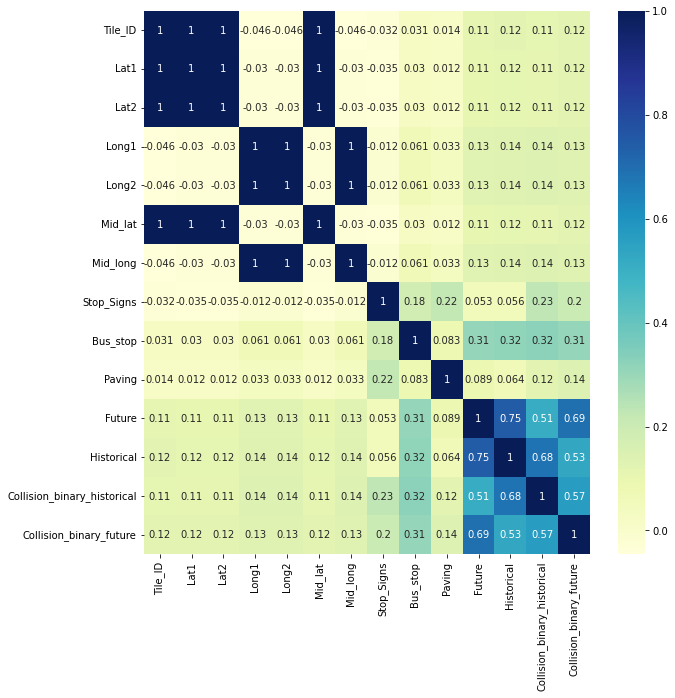

In [46]:
# plotting correlation heatmap
fig, ax = mp.subplots(figsize=(10,10)) 
dataplot = sns.heatmap(tiles.corr(), cmap="YlGnBu", annot=True)

<ipython-input-47-8ee179e018ba>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


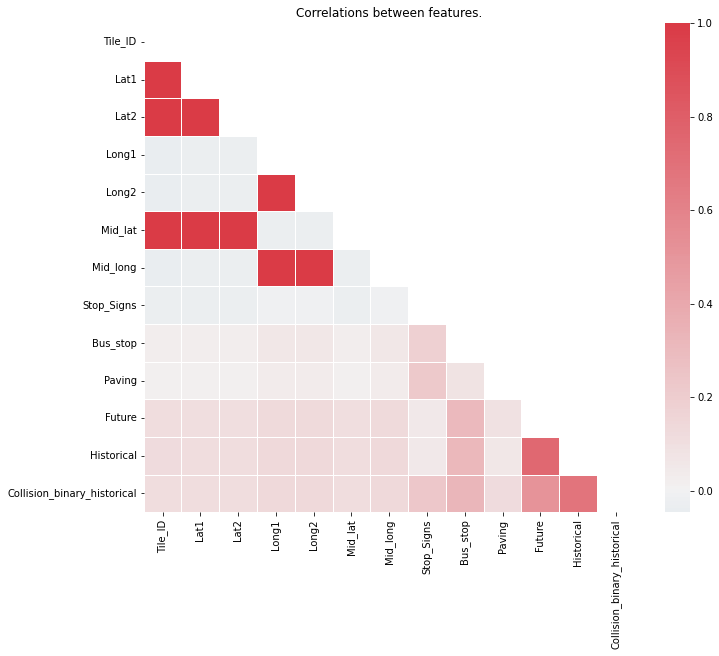

In [47]:
corr = tiles[columns_all[:-1]].corr()
fig, ax = mp.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
mp.title("Correlations between features.")
mp.show()

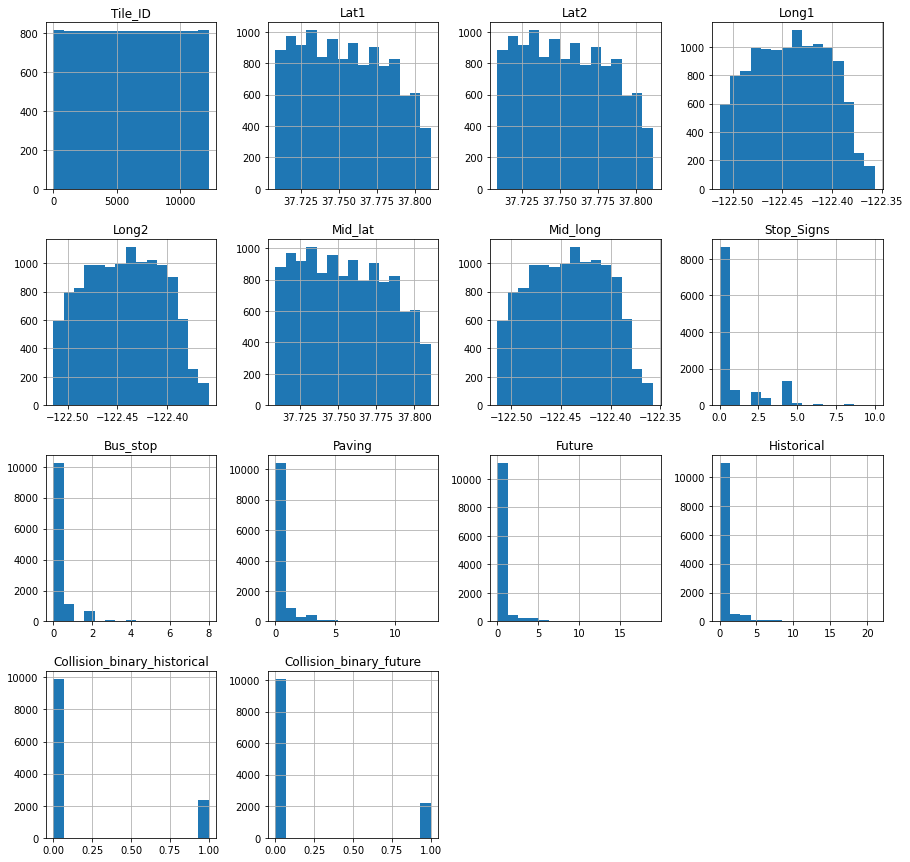

In [48]:
tiles[columns_all[:]].hist(figsize=(15,15), bins=15)
mp.show()

In [49]:
print('How many tiles had the same historical and future number of collisions')
x1 = len(tiles.loc[tiles['Historical'] == tiles['Future']])
print(x1)

print('How many had future number of collisions go up')
x2 = len(tiles.loc[tiles['Historical'] < tiles['Future']])
print(x2)

print('How many had future number of collisions go down')
x3 = len(tiles.loc[tiles['Historical'] > tiles['Future']])
print(x3)

How many tiles had the same historical and future number of collisions
9551
How many had future number of collisions go up
1202
How many had future number of collisions go down
1474


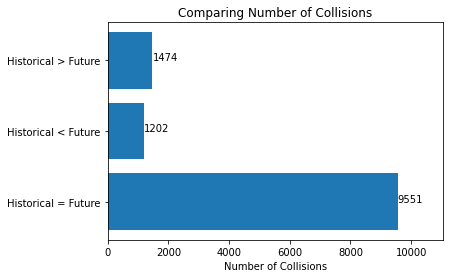

In [50]:
data = {'Historical = Future': x1, 'Historical < Future': x2, 'Historical > Future': x3}
labels = list(data.keys())
values = list(data.values())

fig, ax = mp.subplots()
ax.barh(labels, values)

for i, value in enumerate(values):
    ax.text(value + 3, i, str(value))
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, 1.1*xmax)

mp.title('Comparing Number of Collisions')
mp.xlabel('Number of Collisions')
mp.show()

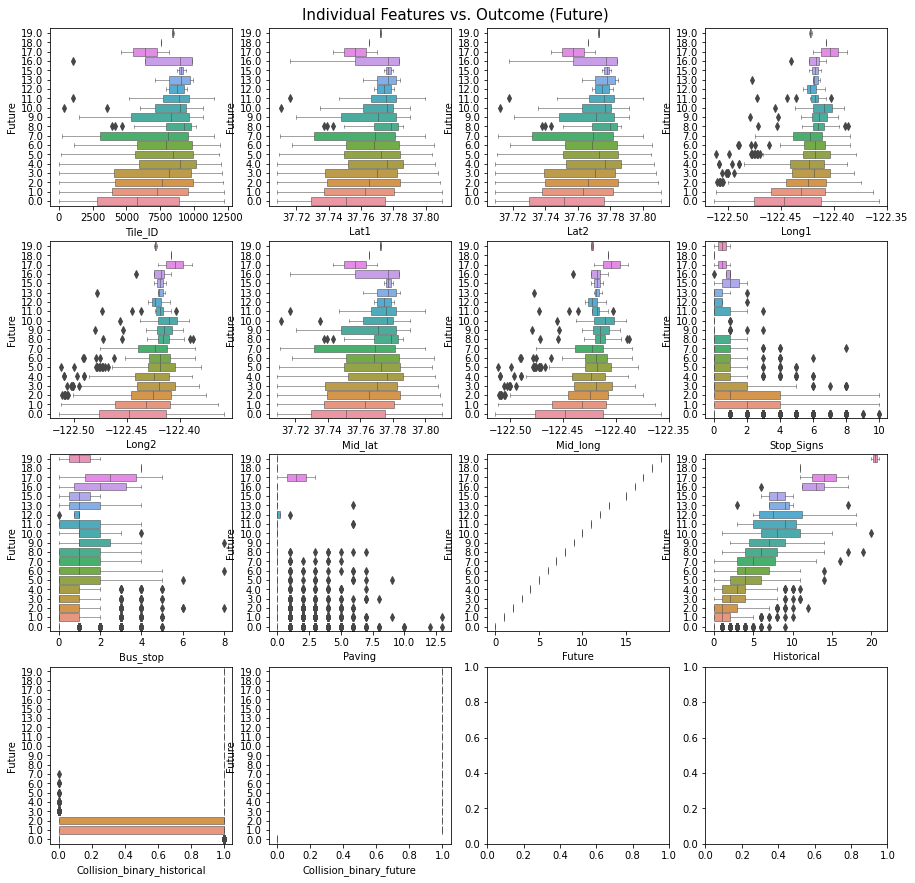

In [51]:
fig, ax_grid = mp.subplots(4, 4, figsize=(15,15))
y = tiles['Future']
for idx, feature in enumerate(columns_all[:]):
    x = tiles[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//4][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (Future)", fontsize=15, y=0.9)
mp.show()

**Dealing with Imbalanced Dataset**

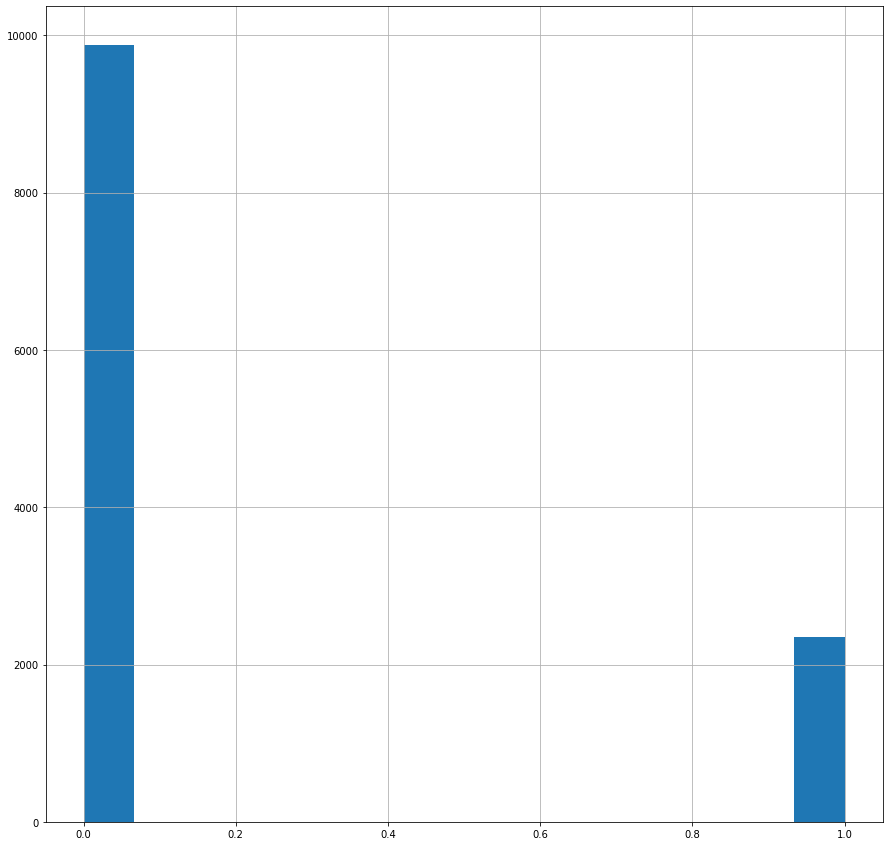

In [52]:
tiles["Collision_binary_historical"].hist(figsize=(15,15), bins=15)
mp.show()

In [53]:
major_count = tiles["Collision_binary_historical"].value_counts()[0]
minor_count = tiles["Collision_binary_historical"].value_counts()[1]
ratio = major_count/minor_count
print("majority class :", major_count)
print("minority class :", minor_count)
print("ratio :", ratio)

majority class : 9875
minority class : 2352
ratio : 4.198554421768708


In [54]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = tiles.loc[tiles["Collision_binary_historical"] == 0]
df_minority = tiles.loc[tiles["Collision_binary_historical"] == 1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=int(major_count/ratio))
df_majority_downsampled = pd.concat([df_majority_downsampled, df_minority])

#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=int(minor_count*ratio))
df_minority_upsampled = pd.concat([df_minority_upsampled, df_majority])


In [55]:
df_majority_downsampled["Collision_binary_historical"].value_counts()

0    2352
1    2352
Name: Collision_binary_historical, dtype: int64

In [56]:
df_minority_upsampled["Collision_binary_historical"].value_counts()

1    9875
0    9875
Name: Collision_binary_historical, dtype: int64

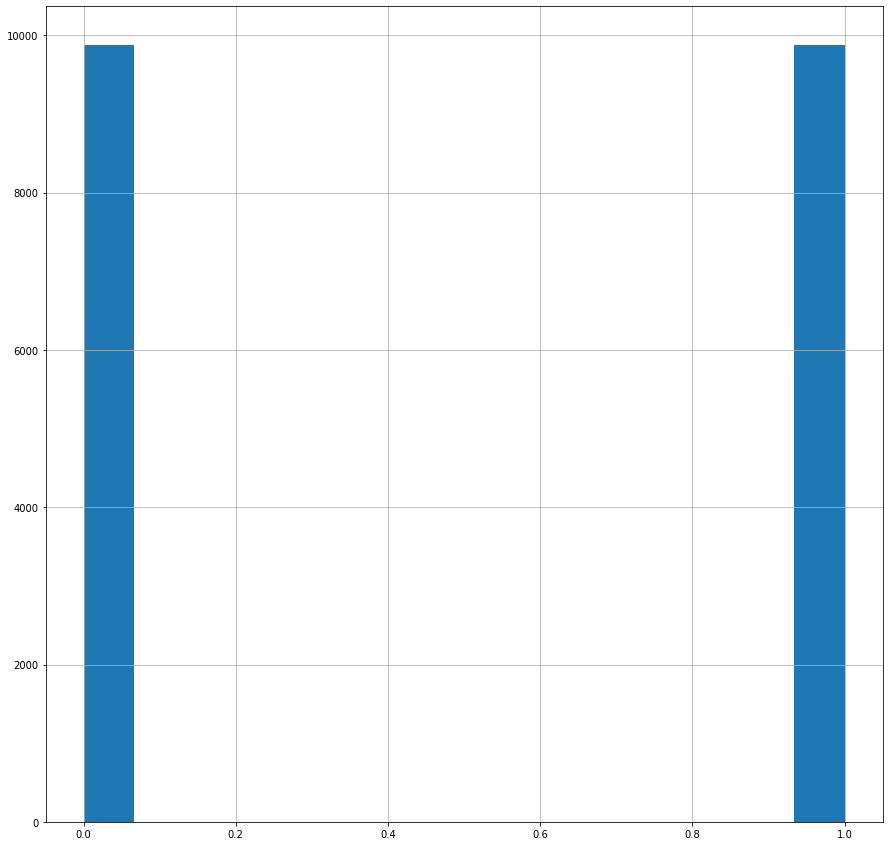

In [57]:
#Use majority downsampled or minority upsampled datasets
#tiles = df_majority_downsampled
tiles = df_minority_upsampled
tiles["Collision_binary_historical"].hist(figsize=(15,15), bins=15)
mp.show()

In [58]:
tiles.head(5)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Future,Historical,Collision_binary_historical,Collision_binary_future
455,455,37.711865,37.712769,-122.401575,-122.402715,37.712317,-122.402145,0.0,5.0,0.0,5.0,6.0,1,1
5680,5680,37.749817,37.750720,-122.488223,-122.489363,37.750269,-122.488793,2.0,0.0,0.0,0.0,1.0,1,0
2788,2788,37.729034,37.729938,-122.374212,-122.375352,37.729486,-122.374782,1.0,1.0,3.0,1.0,1.0,1,1
9610,9610,37.781443,37.782347,-122.412976,-122.414116,37.781895,-122.413546,0.0,1.0,0.0,8.0,6.0,1,1
4548,4548,37.741684,37.742588,-122.423237,-122.424377,37.742136,-122.423807,1.0,1.0,0.0,6.0,5.0,1,1


In [104]:
tiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19750 entries, 455 to 12226
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tile_ID                      19750 non-null  int64  
 1   Lat1                         19750 non-null  float64
 2   Lat2                         19750 non-null  float64
 3   Long1                        19750 non-null  float64
 4   Long2                        19750 non-null  float64
 5   Mid_lat                      19750 non-null  float64
 6   Mid_long                     19750 non-null  float64
 7   Stop_Signs                   19750 non-null  float64
 8   Bus_stop                     19750 non-null  float64
 9   Paving                       19750 non-null  float64
 10  Future                       19750 non-null  float64
 11  Historical                   19750 non-null  float64
 12  Collision_binary_historical  19750 non-null  int64  
 13  Collision_bina

In [78]:
#select features prior modeling
columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
       'Collision_binary_historical', 'Collision_binary_future']

# x: 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
#    'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
#    'Collision_binary_historical'
# y: 'Collision_binary_future'

In [140]:
tiles.rename(columns={'Collision_binary_future': 'label'})

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Future,Historical,Collision_binary_historical,label
455,455,37.711865,37.712769,-122.401575,-122.402715,37.712317,-122.402145,0.0,5.0,0.0,5.0,6.0,1,1
5680,5680,37.749817,37.750720,-122.488223,-122.489363,37.750269,-122.488793,2.0,0.0,0.0,0.0,1.0,1,0
2788,2788,37.729034,37.729938,-122.374212,-122.375352,37.729486,-122.374782,1.0,1.0,3.0,1.0,1.0,1,1
9610,9610,37.781443,37.782347,-122.412976,-122.414116,37.781895,-122.413546,0.0,1.0,0.0,8.0,6.0,1,1
4548,4548,37.741684,37.742588,-122.423237,-122.424377,37.742136,-122.423807,1.0,1.0,0.0,6.0,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12222,12222,37.810358,37.811262,-122.415256,-122.416396,37.810810,-122.415826,0.0,0.0,0.0,0.0,0.0,0,0
12223,12223,37.810358,37.811262,-122.416396,-122.417536,37.810810,-122.416966,0.0,0.0,0.0,0.0,0.0,0,0
12224,12224,37.810358,37.811262,-122.417536,-122.418676,37.810810,-122.418106,0.0,0.0,0.0,0.0,0.0,0,0
12225,12225,37.810358,37.811262,-122.418676,-122.419816,37.810810,-122.419246,0.0,0.0,0.0,0.0,0.0,0,0


**Linear Classifier**

Source: https://www.guru99.com/linear-classifier-tensorflow.html

In [200]:
df_train, df_test = train_test_split(tiles[columns], test_size=0.2)

In [209]:
continuous_features = [tf.feature_column.numeric_column(k) for k in columns]

In [210]:
#Source: https://www.guru99.com/linear-classifier-tensorflow.html
model = tf.estimator.LinearClassifier(
    n_classes = 2,
    model_dir="ongoing/train", 
    feature_columns=continuous_features)

In [211]:
FEATURES = columns
LABEL= 'Collision_binary_future'
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
       x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
       y = pd.Series(data_set[LABEL].values),
       batch_size=n_batch,   
       num_epochs=num_epochs,
       shuffle=shuffle)

In [212]:
model.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

In [213]:
model.evaluate(input_fn=get_input_fn(df_test, 
                                      num_epochs=1,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

{'accuracy': 1.0,
 'accuracy_baseline': 0.6635443,
 'auc': 1.0,
 'auc_precision_recall': 1.0,
 'average_loss': 0.0040383767,
 'label/mean': 0.3364557,
 'loss': 0.004057587,
 'precision': 1.0,
 'prediction/mean': 0.3333422,
 'recall': 1.0,
 'global_step': 10158}

In [145]:
#x_train.head()
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15800 entries, 11573 to 8345
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tile_ID                      15800 non-null  float64
 1   Lat1                         15800 non-null  float64
 2   Lat2                         15800 non-null  float64
 3   Long1                        15800 non-null  float64
 4   Long2                        15800 non-null  float64
 5   Mid_lat                      15800 non-null  float64
 6   Mid_long                     15800 non-null  float64
 7   Stop_Signs                   15800 non-null  float64
 8   Bus_stop                     15800 non-null  float64
 9   Paving                       15800 non-null  float64
 10  Future                       15800 non-null  float64
 11  Historical                   15800 non-null  float64
 12  Collision_binary_historical  15800 non-null  float64
dtypes: float64(13

In [146]:
#x_test.head()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3950 entries, 4262 to 3206
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tile_ID                      3950 non-null   float64
 1   Lat1                         3950 non-null   float64
 2   Lat2                         3950 non-null   float64
 3   Long1                        3950 non-null   float64
 4   Long2                        3950 non-null   float64
 5   Mid_lat                      3950 non-null   float64
 6   Mid_long                     3950 non-null   float64
 7   Stop_Signs                   3950 non-null   float64
 8   Bus_stop                     3950 non-null   float64
 9   Paving                       3950 non-null   float64
 10  Future                       3950 non-null   float64
 11  Historical                   3950 non-null   float64
 12  Collision_binary_historical  3950 non-null   float64
dtypes: float64(13)


In [147]:
y_train#.head()

11573    1.0
10648    1.0
2157     0.0
9821     1.0
5572     0.0
        ... 
5003     0.0
7698     1.0
8015     0.0
8692     0.0
8345     1.0
Name: Collision_binary_future, Length: 15800, dtype: float64

In [148]:
y_test#.head()

4262     0.0
10682    0.0
7990     0.0
5192     0.0
3671     0.0
        ... 
3906     0.0
2353     0.0
12069    0.0
479      1.0
3206     1.0
Name: Collision_binary_future, Length: 3950, dtype: float64

**LOGISTIC REGRESSION**

In [219]:
#from sklearn.preprocessing import LabelEncoder
# split into input (X) and output (Y) variables
x = tiles[columns].iloc[:,12].astype(float)
y = tiles[columns].iloc[:,13].astype(float)
# encode class values as integers
#encoder = LabelEncoder()
#encoder.fit(y)
#encoded_Y = encoder.transform(y)
#y = encoded_Y

In [220]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
                                  test_size=0.2, shuffle=True, random_state=104)

In [221]:
def build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten())
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model

In [222]:
model = build_model(learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = x_train,   # our binary training examples
  y = y_train,   # corresponding binary labels
  epochs=20,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.2, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history_df = pd.DataFrame(history.history)
display(history_df)

Epoch 1/20
198/198 [==============================] - 1s 3ms/step - loss: 0.6695 - binary_accuracy: 0.7679 - val_loss: 0.6000 - val_binary_accuracy: 0.7696
Epoch 2/20
198/198 [==============================] - 0s 2ms/step - loss: 0.5685 - binary_accuracy: 0.7679 - val_loss: 0.5434 - val_binary_accuracy: 0.7696
Epoch 3/20
198/198 [==============================] - 1s 3ms/step - loss: 0.5316 - binary_accuracy: 0.7679 - val_loss: 0.5224 - val_binary_accuracy: 0.7696
Epoch 4/20
198/198 [==============================] - 1s 3ms/step - loss: 0.5167 - binary_accuracy: 0.7679 - val_loss: 0.5126 - val_binary_accuracy: 0.7696
Epoch 5/20
198/198 [==============================] - 0s 2ms/step - loss: 0.5087 - binary_accuracy: 0.7679 - val_loss: 0.5066 - val_binary_accuracy: 0.7696
Epoch 6/20
198/198 [==============================] - 1s 3ms/step - loss: 0.5034 - binary_accuracy: 0.7679 - val_loss: 0.5022 - val_binary_accuracy: 0.7696
Epoch 7/20
198/198 [==============================] - 0s 2ms/ste

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.669535,0.76788,0.599975,0.76962
1,0.568460,0.76788,0.543415,0.76962
2,0.531641,0.76788,0.522355,0.76962
3,0.516656,0.76788,0.512619,0.76962
4,0.508721,0.76788,0.506632,0.76962
5,0.503365,0.76788,0.502164,0.76962
6,0.499171,0.76788,0.498450,0.76962
7,0.495621,0.76788,0.495244,0.76962
8,0.492548,0.76788,0.492441,0.76962
9,0.489851,0.76788,0.489936,0.76962


In [227]:
def plot_loss(history):
    mp.plot(history.history['loss'], label='loss')
    mp.plot(history.history['val_loss'], label='val_loss')
    #mp.plot(history.history['binary_accuracy'], label='binary_accuracy')
    #mp.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
    mp.ylim([0, max(history.history['loss'])])
    mp.xlabel('Epoch')
    mp.ylabel('Loss')
    mp.legend()
    mp.grid(True)

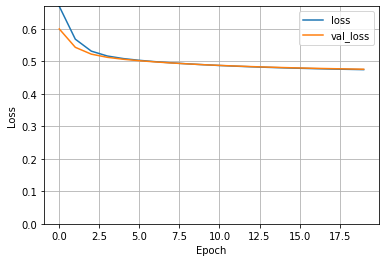

In [228]:
plot_loss(history)

In [225]:
def plot_loss(history):
    #mp.plot(history.history['loss'], label='loss')
    #mp.plot(history.history['val_loss'], label='val_loss')
    mp.plot(history.history['binary_accuracy'], label='binary_accuracy')
    mp.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
    mp.ylim([0, max(history.history['binary_accuracy'])])
    mp.xlabel('Epoch')
    mp.ylabel('Accuracy')
    mp.legend()
    mp.grid(True)

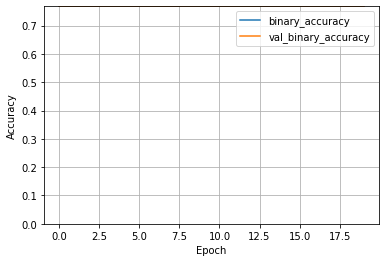

In [226]:
plot_loss(history)

In [229]:
test_predictions = model.predict(x_test).flatten()
print(test_predictions.shape)
print(test_predictions)

124/124 [==============================] - 0s 2ms/step
(3950,)
[0.12916625 0.5759778  0.12916625 ... 0.5759778  0.12916625 0.5759778 ]


In [230]:
test_predictions[test_predictions < 0.5] = 0
test_predictions[test_predictions >= 0.5] = 1
print("Accuracy = ", np.average(y_test == test_predictions))

Accuracy =  0.769367088607595


**LINEAR REGRESSION**

In [231]:
from tensorflow.keras import layers
from tensorflow.keras import activations

def create_linear_model():

    input = tf.keras.layers.Input(shape=(6,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    #linear_model.add(layers.Dense(64, activation='sigmoid'))

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' ,
        metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train[['Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving', 'Bus_stop']]).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


KeyError: ignored

In [ ]:
def plot_loss(history):
    mp.plot(history.history['loss'], label='loss')
    mp.plot(history.history['val_loss'], label='val_loss')
    #mp.plot(history.history['binary_accuracy'], label='binary_accuracy')
    #mp.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
    mp.ylim([0, max(history.history['loss'])])
    mp.xlabel('Epoch')
    mp.ylabel('Loss')
    mp.legend()
    mp.grid(True)

In [ ]:
plot_loss(history)